# Exploratory data analysis

In [38]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('../code'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)

print(f"Current working directory: {os.getcwd()}")
print(f"Source code is in system path @ {sys.path[0]}")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Current working directory: /Users/joshgowdy/GitHub/GB-energy-trading/notebooks
Source code is in system path @ /Users/joshgowdy/GitHub/GB-energy-trading/code


In [ ]:
from loadin import load_auction_data, load_forecasts
from utils import find_loc_null, get_sample_with_missing_values
from preprocessing import Imputer, plot_imputations, evaluate_imputations, test_imputations, STL_decompose_data, preprocess_data
from feature_engineering import pre_engineer_timeseries, make_new_price_indicators

## Load in Auction Data

In [225]:
df1=pd.read_csv('../data/raw/auction_data.csv', delimiter=';')
df2=pd.read_csv('../data/raw/system_prices.csv', delimiter=';')

duplicated day because of daylight savings

In [226]:
df1[df1['Date (WET)']=='[31/10/2021 01:00]']

,Date (WET),price_first_auction,price_second_auction,traded_volume_first_auction,traded_volume_second_auction,price_reference_forecast_first_auction
7273,[31/10/2021 01:00],134,160,3186.8,6260.8,93.33
7274,[31/10/2021 01:00],118.3,99.83,3195.3,6249.8,-38.47


In [227]:
df2[df2['Date (WET)']=='[31/10/2021 01:00]']

,Date (WET),reference_forecast_system_price_low,reference_forecast_system_price_high,system_price
7273,[31/10/2021 01:00],73.49,168.67,170
7274,[31/10/2021 01:00],80.02,161.99,132.95


In [228]:
auction_data, reference_target_forecasts=load_auction_data(['../data/raw/auction_data.csv', '../data/raw/system_prices.csv'])
display(auction_data.head())

,price_first_auction,price_second_auction,traded_volume_first_auction,traded_volume_second_auction,system_price
date,,,,,
2021-01-01 00:00:00,68.0,65.73,2923.7,5102.4,73.15
2021-01-01 01:00:00,62.7,64.96,2825.0,4771.5,71.95
2021-01-01 02:00:00,56.0,60.47,2611.4,4176.2,54.56
2021-01-01 03:00:00,50.1,52.50,2669.3,3755.9,70.73
2021-01-01 04:00:00,50.0,48.98,2741.4,4047.5,54.98


## First look and plot

In [229]:
auction_data.describe()

,price_first_auction,price_second_auction,traded_volume_first_auction,traded_volume_second_auction,system_price
count,14878.000000,14878.000000,14878.000000,14876.000000,14834.000000
mean,157.856348,157.366823,3988.228794,9769.885063,152.034917
std,112.806604,114.772445,1071.437145,2768.401968,145.319843
min,-24.900000,-50.000000,991.800000,3329.200000,-90.320000
25%,77.862500,78.032500,3203.800000,7536.000000,73.512500
50%,138.350000,137.150000,3941.300000,9796.700000,123.715000
75%,201.500000,200.047500,4672.275000,11799.725000,203.000000
max,1860.000000,2500.010000,8459.600000,18419.100000,4037.800000


In [230]:
auction_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14880 entries, 2021-01-01 00:00:00 to 2022-09-12 23:00:00
Freq: h
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   price_first_auction           14878 non-null  float64
 1   price_second_auction          14878 non-null  float64
 2   traded_volume_first_auction   14878 non-null  float64
 3   traded_volume_second_auction  14876 non-null  float64
 4   system_price                  14834 non-null  float64
dtypes: float64(5)
memory usage: 697.5 KB


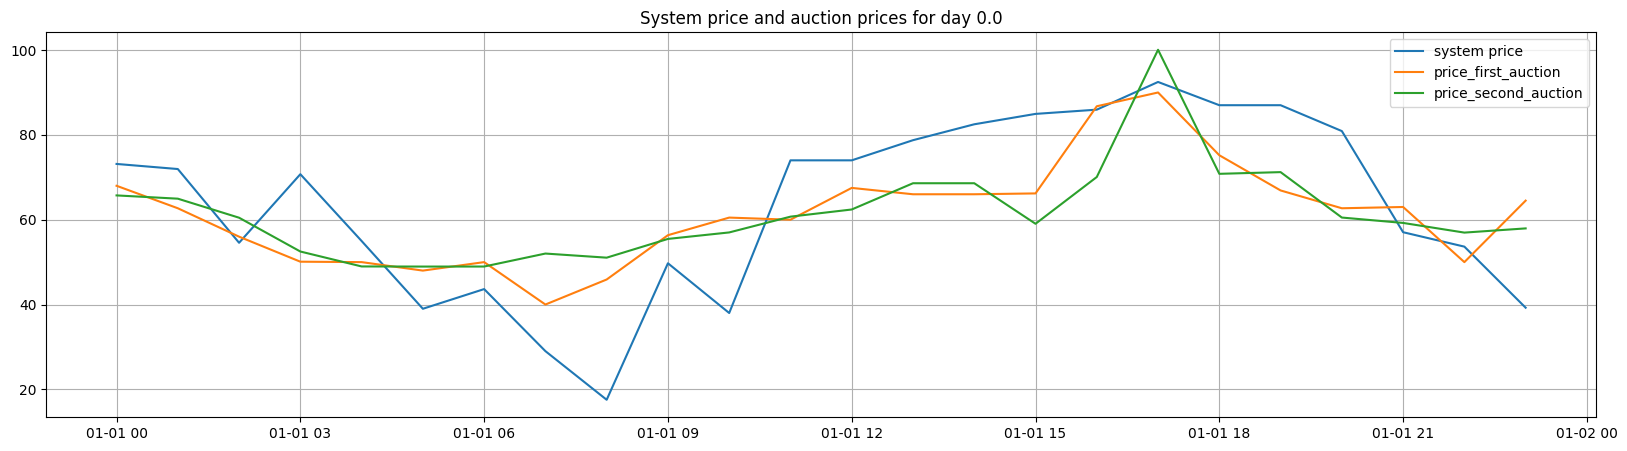

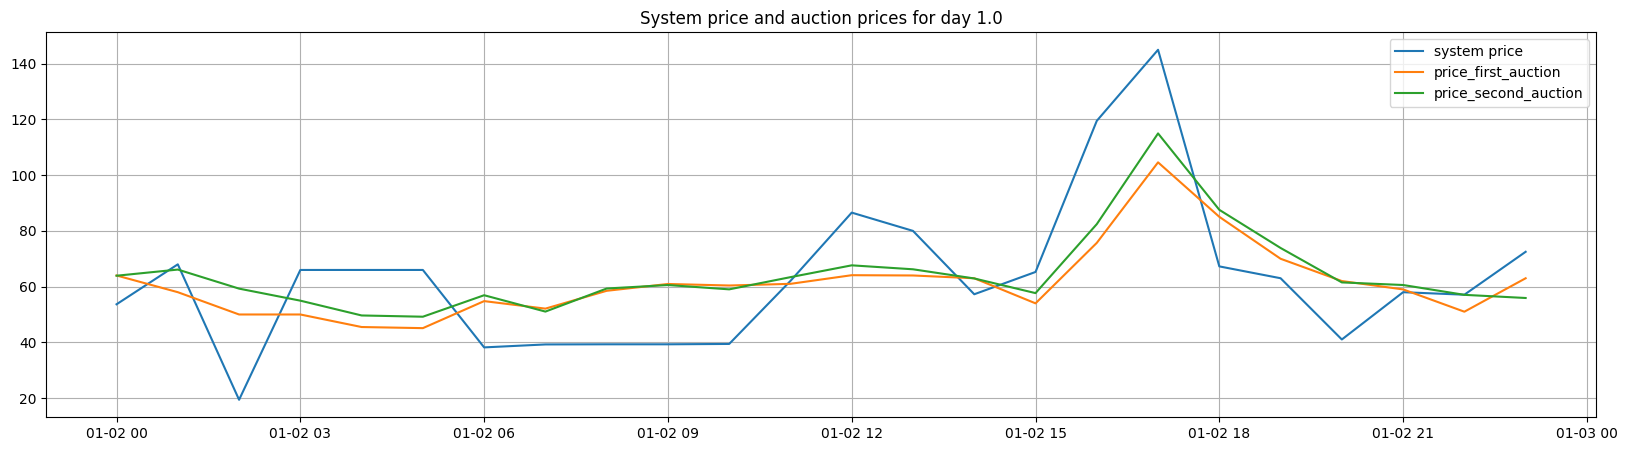

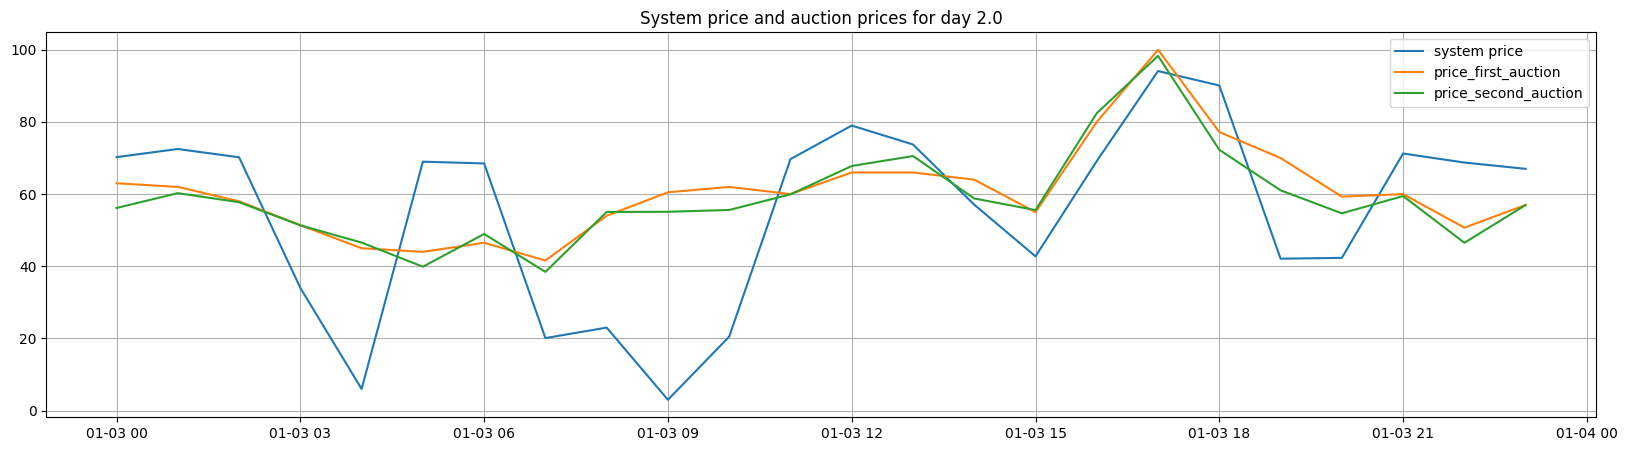

In [231]:
# plot the system price and the auction prices for a few days
days=3
for i in range(0, days*24, 24):
    plt.figure(figsize=(20,5))
    plt.grid()
    plt.plot(auction_data['system_price'].iloc[i:i+24], label='system price')
    plt.plot(auction_data['price_first_auction'].iloc[i:i+24], label='price_first_auction')
    plt.plot(auction_data['price_second_auction'].iloc[i:i+24], label='price_second_auction')
    plt.legend(loc='best')
    plt.title(f'System price and auction prices for day {i/24}')

plot all prices and trade volumes for 2021 2022

Text(0.5, 1.0, 'System price and auction prices')

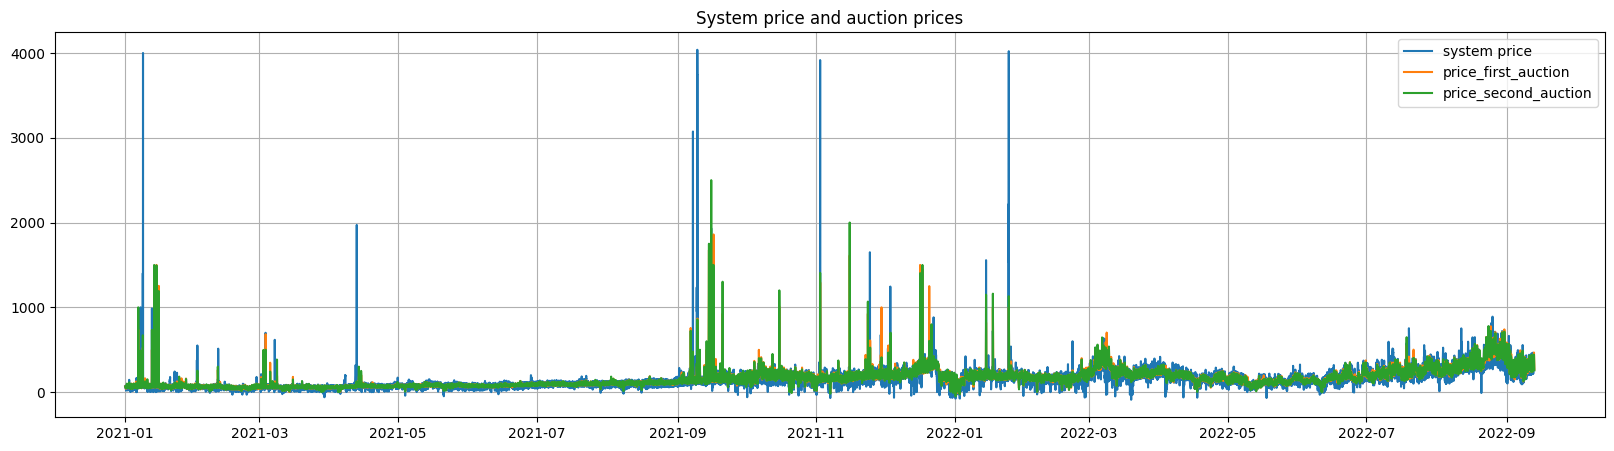

In [232]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(auction_data['system_price'], label='system price')
plt.plot(auction_data['price_first_auction'], label='price_first_auction')
plt.plot(auction_data['price_second_auction'], label='price_second_auction')
plt.legend(loc='best')
plt.title(f'System price and auction prices')

Text(0.5, 1.0, 'Traded volumes')

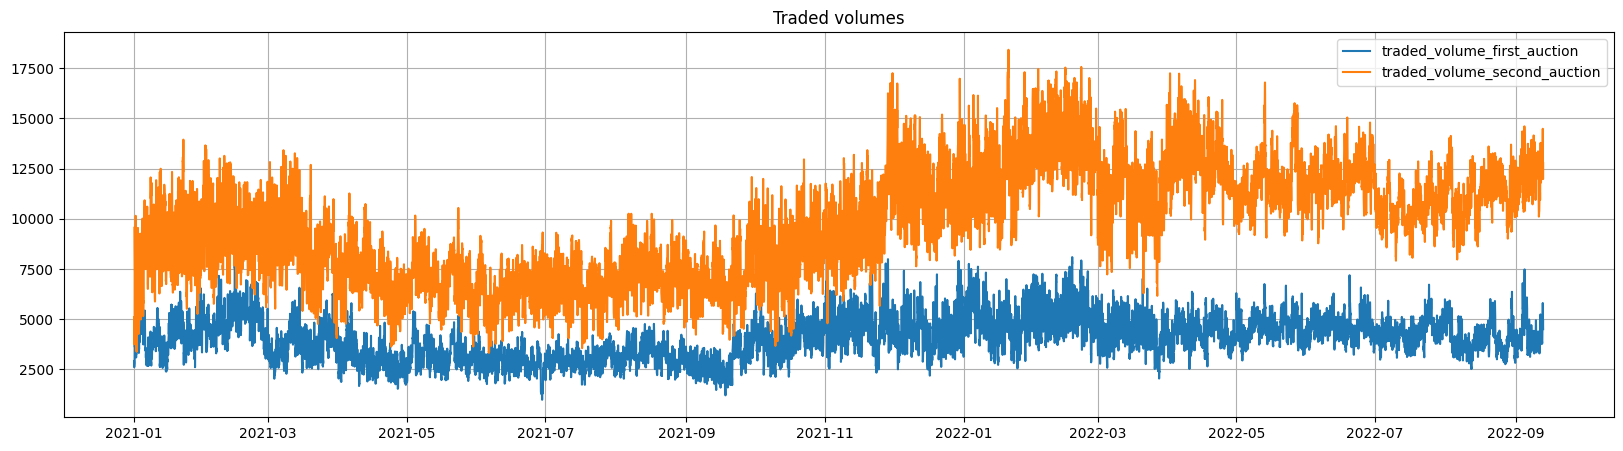

In [233]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(auction_data['traded_volume_first_auction'], label='traded_volume_first_auction')
plt.plot(auction_data['traded_volume_second_auction'], label='traded_volume_second_auction')
plt.legend(loc='best')
plt.title(f'Traded volumes')

Clear 24 hour cycle for auction prices reflecting the daily cycle of solar and demand. Clear correspondence i.e. very strong correlation between two auctions we will be interested in predicting the first auction and then the price difference between auctions.

The second auction has consistently more volume traded. Perhaps as we are close to delivery the volume traded is greater since confidence in generation and demand requirements is higher.

System price exhibits much weaker correlation with the auction prices and a weaker daily cycle. Has much mre volatility. Important to note that the balancing system has much less volume than the day-ahead markets FIND DATA FOR THIS.

## Missing Values and Testing Imputation

find location of null values

In [234]:
find_loc_null(auction_data)

[(600, 'system_price'),
 (601, 'system_price'),
 (602, 'system_price'),
 (603, 'system_price'),
 (604, 'system_price'),
 (605, 'system_price'),
 (606, 'system_price'),
 (607, 'system_price'),
 (608, 'system_price'),
 (609, 'system_price'),
 (610, 'system_price'),
 (611, 'system_price'),
 (612, 'system_price'),
 (613, 'system_price'),
 (614, 'system_price'),
 (615, 'system_price'),
 (616, 'system_price'),
 (617, 'system_price'),
 (618, 'system_price'),
 (619, 'system_price'),
 (620, 'system_price'),
 (621, 'system_price'),
 (622, 'system_price'),
 (658, 'system_price'),
 (659, 'system_price'),
 (660, 'system_price'),
 (661, 'system_price'),
 (662, 'system_price'),
 (663, 'system_price'),
 (664, 'system_price'),
 (665, 'system_price'),
 (666, 'system_price'),
 (667, 'system_price'),
 (668, 'system_price'),
 (669, 'system_price'),
 (670, 'system_price'),
 (2065, 'price_first_auction'),
 (2065, 'price_second_auction'),
 (2065, 'traded_volume_first_auction'),
 (2065, 'traded_volume_second_a

most null values are consequtive entries with a 24 hour window that are missing so we must interpolate. The data exhibits a strong 24 hour cycle. We will try imputing using a rolling mean taken periodically i.e. from the same hour period from a number of past/future days. Similarly we will try a more sophisticated method using an STL decomposition and finally also using an ARIMA model.

In [235]:
sample, sample_missing, dates_missing = get_sample_with_missing_values(auction_data, '2021-01-01', '2021-01-10', 'system_price')

Missing values from 2021-01-06 00:00:00 to 2021-01-06 23:00:00


In [236]:
methods=[('periodic_rolling_mean', {'window_start': 1, 'window_end': 1, 'period': 24}), 
         ('periodic_rolling_mean', {'window_start': 2, 'window_end': 2, 'period': 24}),
         ('periodic_rolling_mean', {'window_start': 3, 'window_end': 3, 'period': 24}),
         ('periodic_rolling_mean', {'window_start': 1, 'window_end': 0, 'period': 24}),
         ('STL_decomposition', {'period': 24, 'iterations':1}),
         ('STL_decomposition', {'period': 24, 'iterations':2}),
         ('STL_ARIMA', {'period':24, 'ARIMA_order':(1,0,1)}),
         ('STL_ARIMA', {'period':24, 'ARIMA_order':(2,0,2)})]

In [237]:
sample_imputed_dict={}
for method, kwargs in methods:
    imputer = Imputer(method, **kwargs)
    sample_imputed_dict[method+'_'+str(list(kwargs.values()))]=imputer.impute(sample_missing, 'system_price')

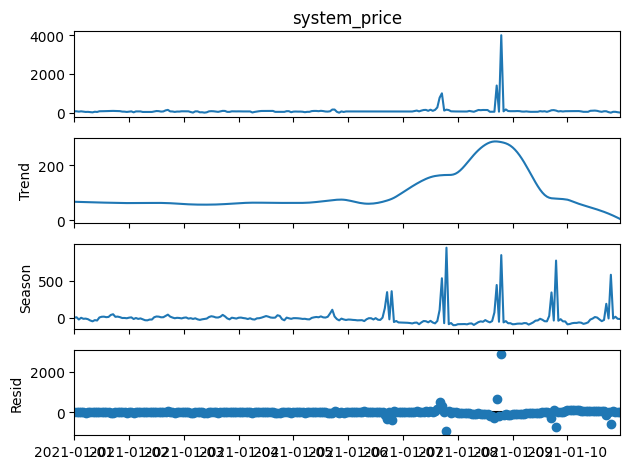

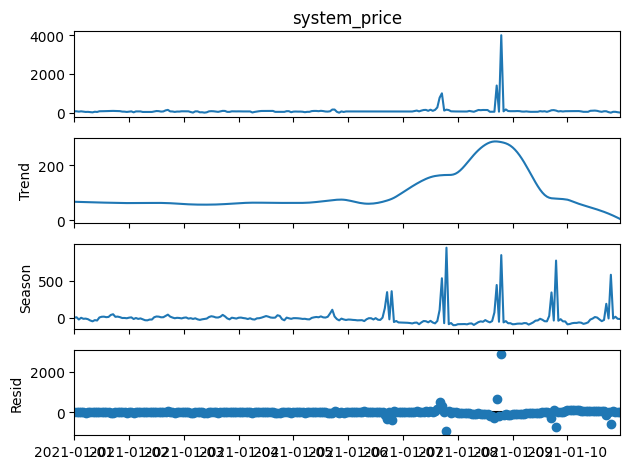

In [238]:
decomposed=STL_decompose_data(sample_missing, 'system_price', 24)
decomposed.plot()

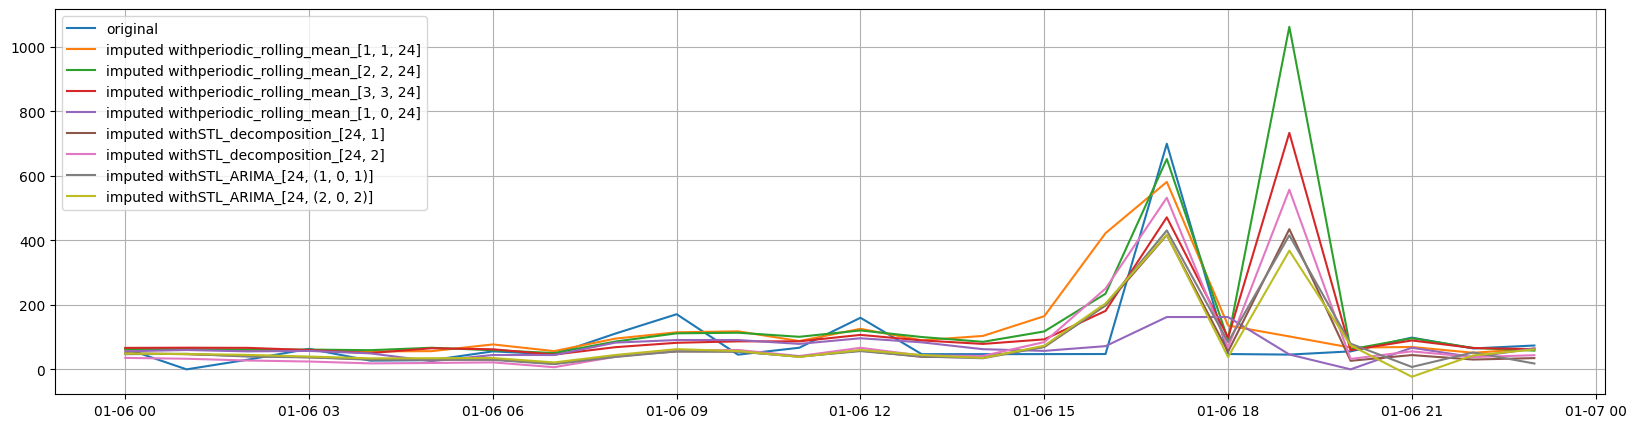

In [239]:
plot_imputations(sample, sample_imputed_dict, dates_missing)

In [240]:
evaluate_imputations(sample, sample_imputed_dict, dates_missing)

,RMSE
Method,
"periodic_rolling_mean_[1, 1, 24]",91.891327
"STL_ARIMA_[24, (2, 0, 2)]",103.289566
"STL_ARIMA_[24, (1, 0, 1)]",108.301242
"STL_decomposition_[24, 1]",110.927997
"periodic_rolling_mean_[1, 0, 24]",116.805354
"STL_decomposition_[24, 2]",124.196947
"periodic_rolling_mean_[3, 3, 24]",154.452542
"periodic_rolling_mean_[2, 2, 24]",214.145973


In [241]:
sample_dates=[('2021-01-01', '2021-01-10'), ('2021-07-01', '2021-07-10'), ('2022-01-01', '2022-01-10'), ('2022-07-01', '2022-07-10')]
price_columns=['system_price', 'price_first_auction', 'price_second_auction', 'traded_volume_first_auction', 'traded_volume_second_auction']

test_imputations(auction_data, price_columns, sample_dates, methods)

Missing values from 2021-01-06 00:00:00 to 2021-01-06 23:00:00
Missing values from 2021-07-06 00:00:00 to 2021-07-06 23:00:00
Missing values from 2022-01-06 00:00:00 to 2022-01-06 23:00:00
Missing values from 2022-07-06 00:00:00 to 2022-07-06 23:00:00


/Users/joshgowdy/GitHub/GB-energy-trading/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/joshgowdy/GitHub/GB-energy-trading/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/joshgowdy/GitHub/GB-energy-trading/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Missing values from 2021-01-06 00:00:00 to 2021-01-06 23:00:00
Missing values from 2021-07-06 00:00:00 to 2021-07-06 23:00:00
Missing values from 2022-01-06 00:00:00 to 2022-01-06 23:00:00
Missing values from 2022-07-06 00:00:00 to 2022-07-06 23:00:00
Missing values from 2021-01-06 00:00:00 to 2021-01-06 23:00:00


/Users/joshgowdy/GitHub/GB-energy-trading/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/joshgowdy/GitHub/GB-energy-trading/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/joshgowdy/GitHub/GB-energy-trading/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/joshgowdy/GitHub/GB-energy-trading/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_re

Missing values from 2021-07-06 00:00:00 to 2021-07-06 23:00:00
Missing values from 2022-01-06 00:00:00 to 2022-01-06 23:00:00
Missing values from 2022-07-06 00:00:00 to 2022-07-06 23:00:00
Missing values from 2021-01-06 00:00:00 to 2021-01-06 23:00:00
Missing values from 2021-07-06 00:00:00 to 2021-07-06 23:00:00
Missing values from 2022-01-06 00:00:00 to 2022-01-06 23:00:00


/Users/joshgowdy/GitHub/GB-energy-trading/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/joshgowdy/GitHub/GB-energy-trading/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/joshgowdy/GitHub/GB-energy-trading/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/joshgowdy/GitHub/GB-energy-trading/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_re

Missing values from 2022-07-06 00:00:00 to 2022-07-06 23:00:00
Missing values from 2021-01-06 00:00:00 to 2021-01-06 23:00:00
Missing values from 2021-07-06 00:00:00 to 2021-07-06 23:00:00
Missing values from 2022-01-06 00:00:00 to 2022-01-06 23:00:00
Missing values from 2022-07-06 00:00:00 to 2022-07-06 23:00:00


/Users/joshgowdy/GitHub/GB-energy-trading/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'system_price':                                        RMSE
 Method                                     
 STL_decomposition_[24, 1]         70.275586
 STL_ARIMA_[24, (2, 0, 2)]         72.374598
 STL_ARIMA_[24, (1, 0, 1)]         72.885710
 STL_decomposition_[24, 2]         73.023864
 periodic_rolling_mean_[1, 1, 24]  78.069714
 periodic_rolling_mean_[3, 3, 24]  78.502193
 periodic_rolling_mean_[1, 0, 24]  96.397207
 periodic_rolling_mean_[2, 2, 24]  96.795183,
 'price_first_auction':                                        RMSE
 Method                                     
 STL_decomposition_[24, 2]         44.984945
 STL_decomposition_[24, 1]         47.304912
 periodic_rolling_mean_[2, 2, 24]  50.196233
 periodic_rolling_mean_[1, 1, 24]  54.759958
 periodic_rolling_mean_[3, 3, 24]  57.961668
 STL_ARIMA_[24, (1, 0, 1)]         58.197821
 STL_ARIMA_[24, (2, 0, 2)]         58.576749
 periodic_rolling_mean_[1, 0, 24]  68.442860,
 'price_second_auction':                                   

best performing imputation on the price data (what we are interested in) is the STL decomposition (possibly with 2 iterations). The only column with actually missing values is system_price for which the best perfoming imputation is STL ceposition with 1 iteration. So thats what we will use.

In [242]:
auction_data=preprocess_data(auction_data)

## Forecasts of Energy Fundamentals and Correlations

In [243]:
forecasts =load_forecasts('../data/raw/forecast_features.csv')
forecasts=preprocess_data(forecasts)

In [244]:
find_loc_null(forecasts)

[]

we look at the correlations within out features

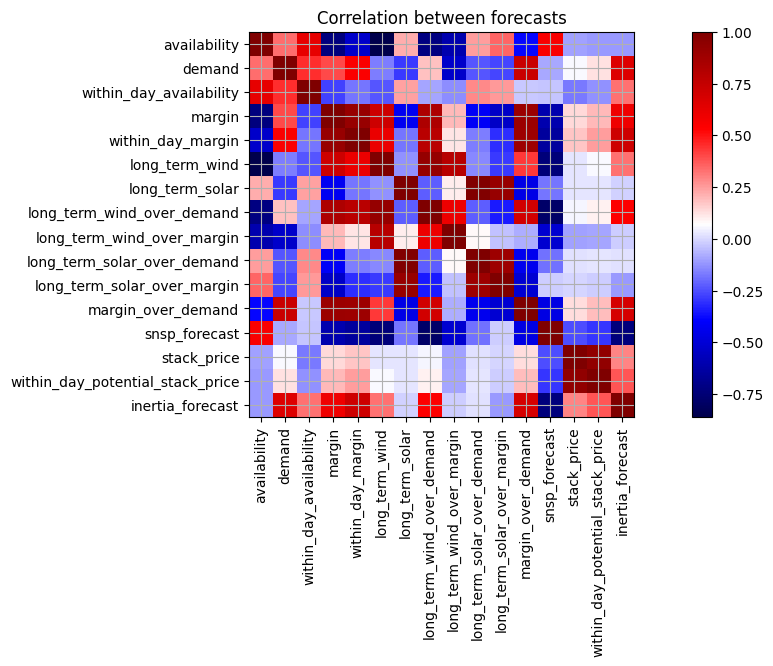

In [245]:
# heat map of correlation between features
plt.figure(figsize=(15,5))
plt.grid()
plt.title('Correlation between forecasts')
plt.imshow(forecasts.corr(), cmap='seismic', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(forecasts.columns)), forecasts.columns, rotation=90)
plt.yticks(range(len(forecasts.columns)), forecasts.columns)
plt.show()

As expected there are strong correlations within the features. Clearly the derived features (e.f. wind over demand) will be correlated to the fundamental features (widn and demand). The price indicators are only weakly correlated with the energy features but are strongly correlated with each other.

Lets look at how correlated the various features are with the auction and system prices.

In [246]:
combined_data = pd.concat([forecasts, auction_data], axis=1)

In [247]:
combined_data_prep=preprocess_data(combined_data)

In [248]:
find_loc_null(combined_data)

[]

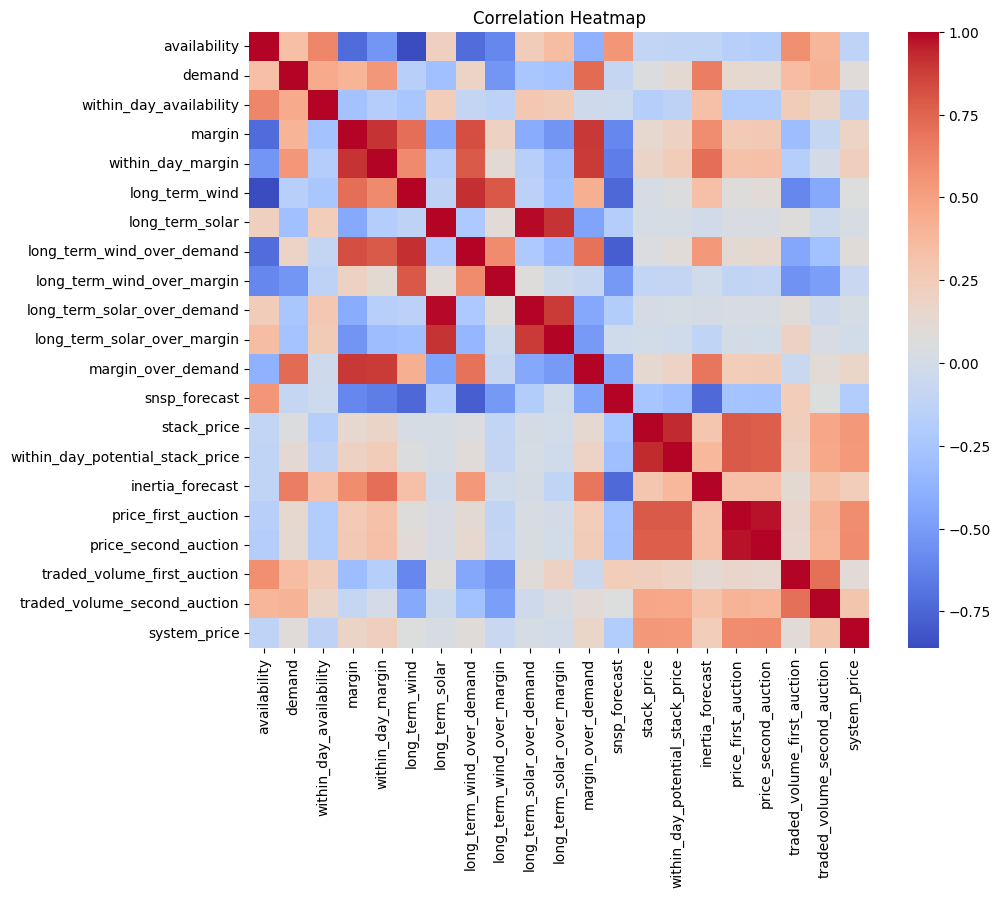

In [249]:
correlation_matrix = combined_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

some light correlations between energy fundamentals and auciton prices.

In [250]:
combined_data[combined_data.describe().columns[1:]].skew(axis=0, skipna=True).sort_values(ascending=False)

system_price                        10.045756
price_second_auction                 3.742381
price_first_auction                  3.204764
within_day_potential_stack_price     1.696171
stack_price                          1.322846
snsp_forecast                        0.376866
traded_volume_first_auction          0.372835
inertia_forecast                     0.262404
demand                               0.176409
traded_volume_second_auction         0.148705
within_day_availability              0.081110
long_term_wind_over_margin          -0.149289
within_day_margin                   -0.305682
margin                              -0.365215
long_term_wind                      -0.434791
long_term_wind_over_demand          -0.717319
margin_over_demand                  -0.737228
long_term_solar                     -1.361610
long_term_solar_over_demand         -1.400435
long_term_solar_over_margin         -2.214209
dtype: float64

We see that a lot of the prices are highly skewed towards larger values. We will thus define log prices to train the model, do this later.

KeyError: 'auction_price_difference'

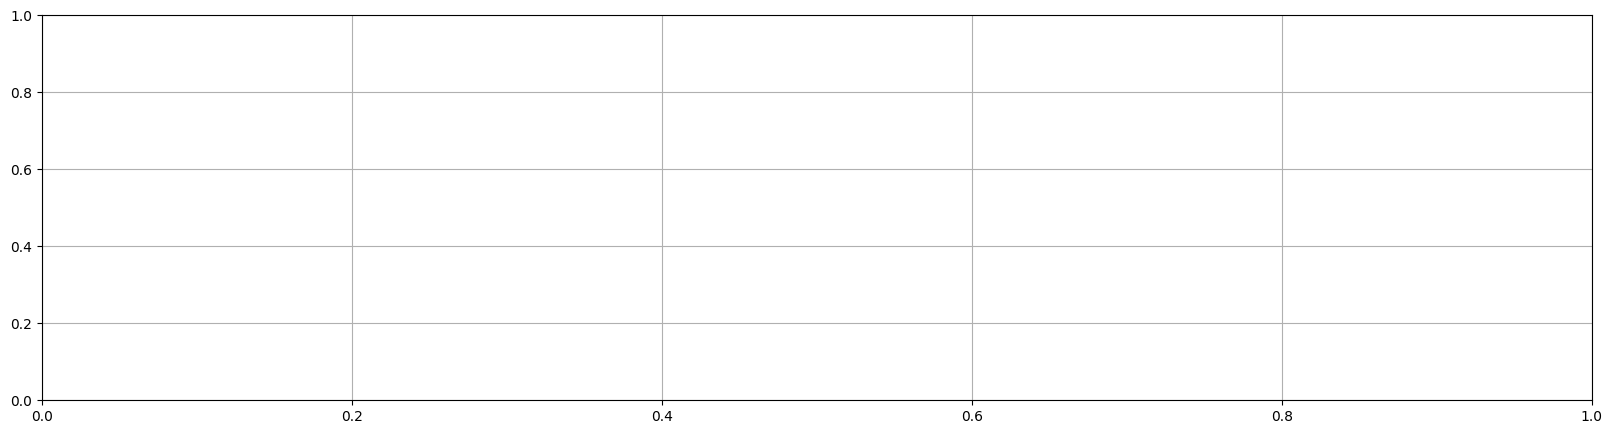

In [251]:
# plot the first auction price and spreads for a few days
days=3
for i in range(0, days*24, 24):
    plt.figure(figsize=(20,5))
    plt.grid()
    plt.plot(auction_data['auction_price_difference'].iloc[i:i+24], label='auction_price_difference')
    plt.plot(auction_data['price_first_auction'].iloc[i:i+24], label='price_first_auction')
    plt.plot(auction_data['system_price_difference'].iloc[i:i+24], label='system_price_difference')
    plt.legend(loc='best')
    plt.title(f'First auction price and spreads for day {i/24}')

Text(0.5, 1.0, 'System price and auction price differences')

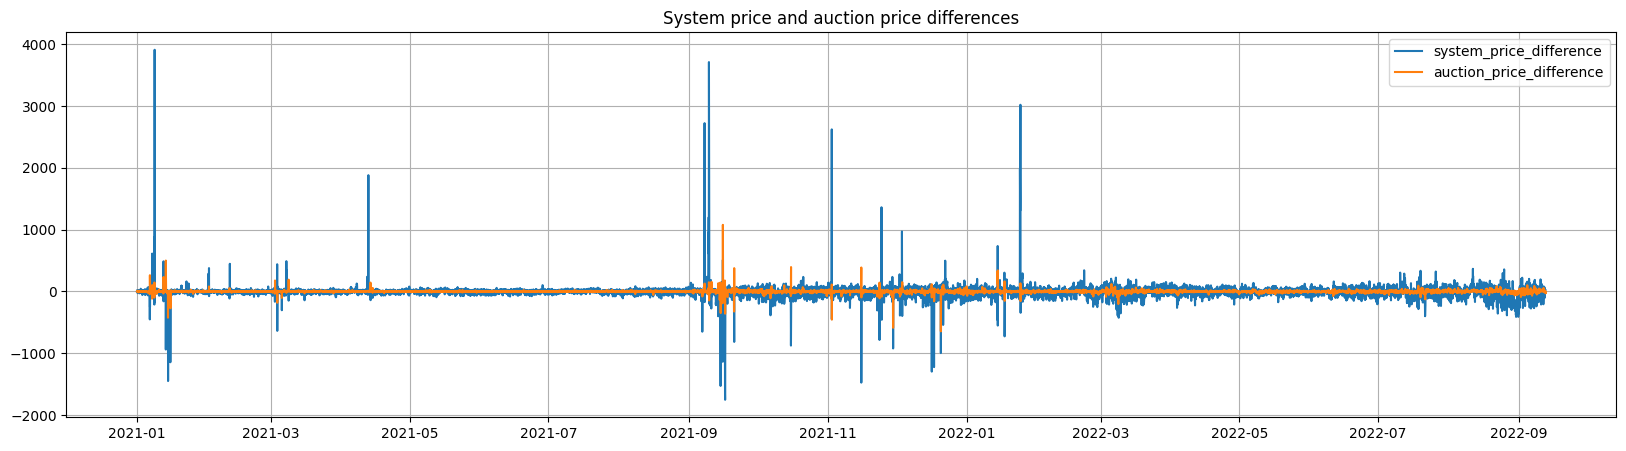

In [ ]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(auction_data['system_price_difference'], label='system_price_difference')
plt.plot(auction_data['auction_price_difference'], label='auction_price_difference')
plt.legend(loc='best')
plt.title(f'System price and auction price differences')

spreads are mean reverting over a shoirter scale! Unlike prices which can trend. Spreads also have a much weaker daily cycle.

Lets build some more custom price indicators

## Price Indicator Engineering

first from the auciton data timeseries we build a lagged 24 hour timeseries

In [292]:
price_data=pre_engineer_timeseries(auction_data)


In [293]:
price_data

,price1,spread1,spread2,price1_lag24,spread1_lag24,spread2_lag24,price1_lag72,spread1_lag72,spread2_lag72,price1_lag168,spread1_lag168,spread2_lag168,price1_close,spread1_close,spread2_close
date,,,,,,,,,,,,,,,
2021-01-01 00:00:00,68.0,-2.27,5.150000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 01:00:00,62.7,2.26,9.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 02:00:00,56.0,4.47,-1.440000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 03:00:00,50.1,2.40,20.630000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 04:00:00,50.0,-1.02,4.980000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-12 19:00:00,465.6,-28.00,-147.286815,422.45,12.55,-207.45,390.6,-4.88,-92.60,400.6,12.64,88.40,289.6,15.44,-14.0
2022-09-12 20:00:00,418.0,-26.55,-58.381621,386.50,32.30,-172.65,358.5,8.37,-80.63,363.5,0.01,111.65,289.6,15.44,-14.0
2022-09-12 21:00:00,358.7,-16.41,-35.786874,325.00,56.41,-110.60,330.0,-6.57,-60.95,305.0,-11.05,136.68,289.6,15.44,-14.0


We wish to define metrics which measure trend, oscillators and momentum.

add indicators all in one go, we will describe these individually below

indicators: 

TREND: Percentage Price Change Moving Average, Average True Range, Moving Average Deviation, Average Directional Movement Index, 

OSCILLATOR: Percentage Range, Relative Strength Index, Moving Average Convergence/Divergence

MOMENTUM: Price Momentum

In [294]:
indicator_methods=[('PPCMA_24', 'calculate_PPCMA', {'window': 24}),
                   ('PPCMA_7', 'calculate_PPCMA', {'window': 7*24}),
                   ('ATR_24', 'calculate_ATR', {'window': 24, 'lag': 24}),
                   ('ATR_7', 'calculate_ATR', {'window': 24, 'lag': 7*24}),
                   ('MAD_24', 'calculate_MAD', {'window': 24}),
                   ('MAD_7', 'calculate_MAD', {'window': 7*24}),
                   ('RSTDEV_24', 'calculate_RSTDEV', {'window': 24}),
                   ('RSTDEV_7', 'calculate_RSTDEV', {'window': 7*24}),
                   ('ZSCORE_24', 'calculate_ZSCORE', {'window': 24}),
                   ('ZSCORE_7', 'calculate_ZSCORE', {'window': 7*24}),
                   ('ADX_24', 'calculate_ADX', {'window': 24}),
                   ('ADX_7', 'calculate_ADX', {'window': 7*24}),
                   ('PR_24', 'calculate_PR', {'window': 24}),
                   ('PR_7', 'calculate_PR', {'window': 7*24}),
                   ('RSI_24', 'calculate_RSI', {'window': 24}),
                   ('RSI_7', 'calculate_RSI', {'window': 7*24}),
                   ('MACD_24', 'calculate_MACD', {'window_smaller': 12, 'window_larger': 24}),
                   ('MACD_7', 'calculate_MACD', {'window_smaller': 7*12, 'window_larger': 7*24}),
                   ('PMOM_1h', 'calculate_PMOM', {'lag':1}),
                   ('PMOM_3h', 'calculate_PMOM', {'lag':3}),
                   ('PMOM_6h', 'calculate_PMOM', {'lag':6}),
                      
]           

In [295]:
timeseries=['price1_lag24', 'spread1_lag24', 'spread2_lag24']
price_data=make_new_price_indicators(price_data, timeseries, indicator_methods)

In [296]:
price_data.columns

Index(['price1', 'spread1', 'spread2', 'price1_lag24', 'spread1_lag24',
       'spread2_lag24', 'price1_lag72', 'spread1_lag72', 'spread2_lag72',
       'price1_lag168', 'spread1_lag168', 'spread2_lag168', 'price1_close',
       'spread1_close', 'spread2_close', 'price1_lag24_PPCMA_24',
       'price1_lag24_PPCMA_7', 'price1_lag24_ATR_24', 'price1_lag24_ATR_7',
       'price1_lag24_MAD_24', 'price1_lag24_MAD_7', 'price1_lag24_RSTDEV_24',
       'price1_lag24_RSTDEV_7', 'price1_lag24_ZSCORE_24',
       'price1_lag24_ZSCORE_7', 'price1_lag24_ADX_24', 'price1_lag24_ADX_7',
       'price1_lag24_PR_24', 'price1_lag24_PR_7', 'price1_lag24_RSI_24',
       'price1_lag24_RSI_7', 'price1_lag24_MACD_24', 'price1_lag24_MACD_7',
       'price1_lag24_PMOM_1h', 'price1_lag24_PMOM_3h', 'price1_lag24_PMOM_6h',
       'spread1_lag24_PPCMA_24', 'spread1_lag24_PPCMA_7',
       'spread1_lag24_ATR_24', 'spread1_lag24_ATR_7', 'spread1_lag24_MAD_24',
       'spread1_lag24_MAD_7', 'spread1_lag24_RSTDEV_24',
  

### Trend Indicators

Trend indicators measure whether prices are rising or falling on average. In our case there is a strong daily cycle dictaing hourly behaviour, so we test whether prices are rising/falling between days i.e. deviating from this behaviour.

1. We first define a 24 hour rolling average percentage price change. We call it a Percentage Price Change Moving Average (PPCMA_24).

Measures the average rising or falling of prices.

Text(0.5, 1.0, 'PPCMA for auction_price_difference')

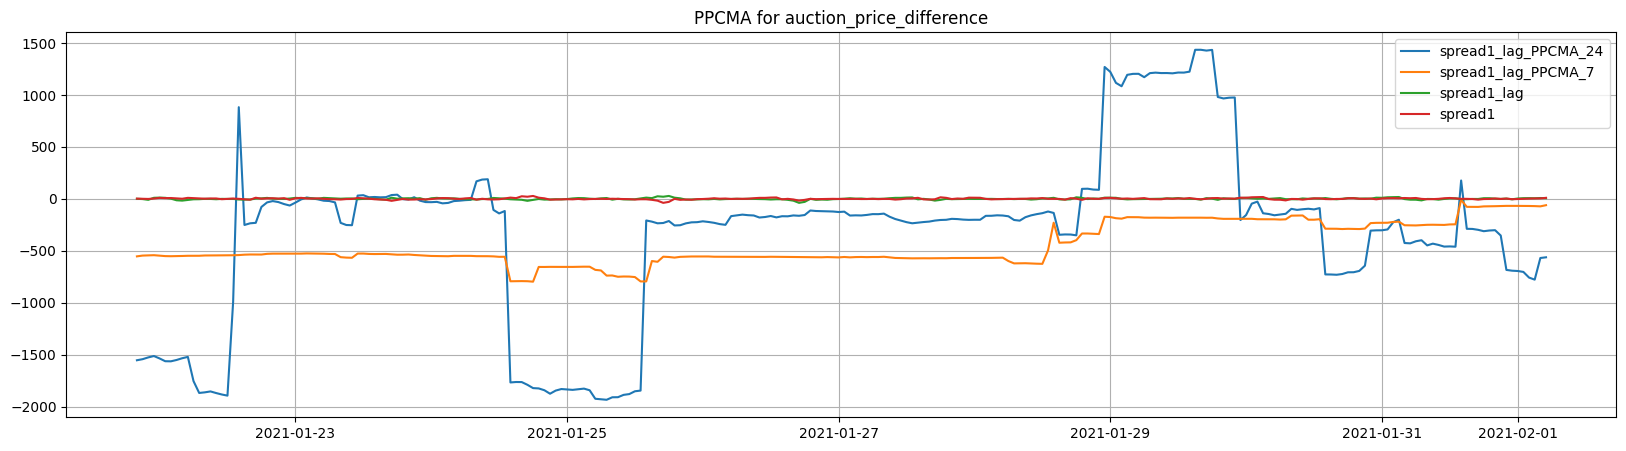

In [289]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(price_data['spread1_lag24_PPCMA_24'].iloc[500:750], label='spread1_lag_PPCMA_24')
plt.plot(price_data['spread1_lag24_PPCMA_7'].iloc[500:750], label='spread1_lag_PPCMA_7')
plt.plot(price_data['spread1_lag24'].iloc[500:750], label='spread1_lag')
plt.plot(price_data['spread1'].iloc[500:750], label='spread1')
plt.legend(loc='best')
plt.title(f'PPCMA for auction_price_difference')

2. We also define a Moving Average Deviation (MAD): A trend energy market indicator that uses Price Moving Average (PMA) to calculate the deviation rate of the current electricity price from PMA. The moving average deviation is calculated using a rolling 24-hour window.

Positive MAD means the price is breaking out above of its averages.

3. Average Directional Movement Index (ADX): A trend energy market indicator measuring the strength of the trend, grouping the two directional movement indexes depending on whether price change, calculated as current electricity price minus previous 24-hour price, is grouped as a Price Up (positive) change or Price Down (negative) change. The two indexes are combined and smoothed with a moving average.

Another trend/oscilator is the Z score whihc measures the distance from the rolling mean in units of the STDEV

### Volatility Indicators

4. We now define a volatility metric which looks are the maximum price changes within 24 hours.

We define the Average True Range (ATR): A trend energy market indicator measuring price volatility. Over a 24-hour window, there are three different values calculated: (a) highest price minus lowest price; (b) highest price minus a 24-hour lagged electricity price; and (c) lowest price minus a 24-hour lagged electricity price. The maximum of these three values is selected for each trading hour and averaged over a rolling 24-hour window. 

High ATR means high volatility.

Text(0.5, 1.0, 'ATR for first auction price')

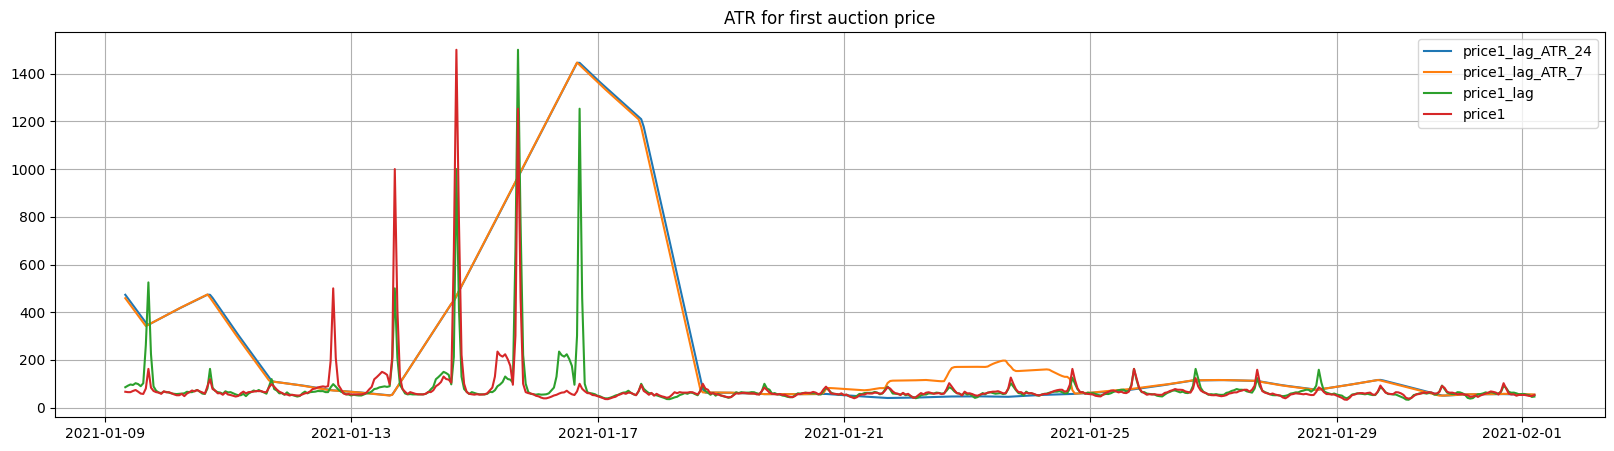

In [290]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(price_data['price1_lag24_ATR_24'].iloc[200:750], label='price1_lag_ATR_24')
plt.plot(price_data['price1_lag24_ATR_7'].iloc[200:750], label='price1_lag_ATR_7')
plt.plot(price_data['price1_lag24'].iloc[200:750], label='price1_lag')
plt.plot(price_data['price1'].iloc[200:750], label='price1')
plt.legend(loc='best')
plt.title(f'ATR for first auction price')

Another volatility indicator is the rolling STDEV

### Oscilator indicators

5. Percentage Range (PR): An oscillator energy market indicator that finds a relationship between current electricity price and the highest/lowest prices. This indicator oscillates between 0 and 100, with a value tending towards 100 signifying that the current electricity price is closer to the lowest price and a value towards 0 signifying that the current electricity price is tending towards the highest price. The percentage range is calculated over a 24-hour window.

6. Relative Strength Index (RSI): An oscillator energy market indicator that compares recent price gains to recent price losses. This indicator oscillates between 0 and 100, with a value close to 100 signifying that the majority of electricity price units within the period are Price Up and a value close to 0 signifying that the majority of electricity price units are Price Down. Price Up is the average of the previous 24 h when price difference increased, and Price Down is the average of the previous 24 h when price difference decreased.

7. Moving Average Convergence/Divergence (MACD): An oscillator energy market indicator that takes into consideration the strength, direction, and duration of the trend as well as price momentum. It compares moving averages of previous price values with rolling window of two different sizes e.g. 12 and 24 for the 24-hour model.

### Momentum Indicators

Finally, we define a momentum indicator of short term price gains.

8. Price Momentum (PMOM): A momentum energy market indicator that evaluates the power of the market by examining the current electricity price with the previous trading value (1 h before). 

This may not be very useful since the prices exhibit a 24 hour cycle and bids and offers are placed in each auction for 24 hours simulaneously so no one in the market is looking at hour by hour price changes. Still this momentum measure should help the model learn the 24 hour cycle and breakouts from it.

May be useful for system_price which involves real time balancing and so can have high or low momentum hour by hour based on NESO decision making to balance the health of the grid.

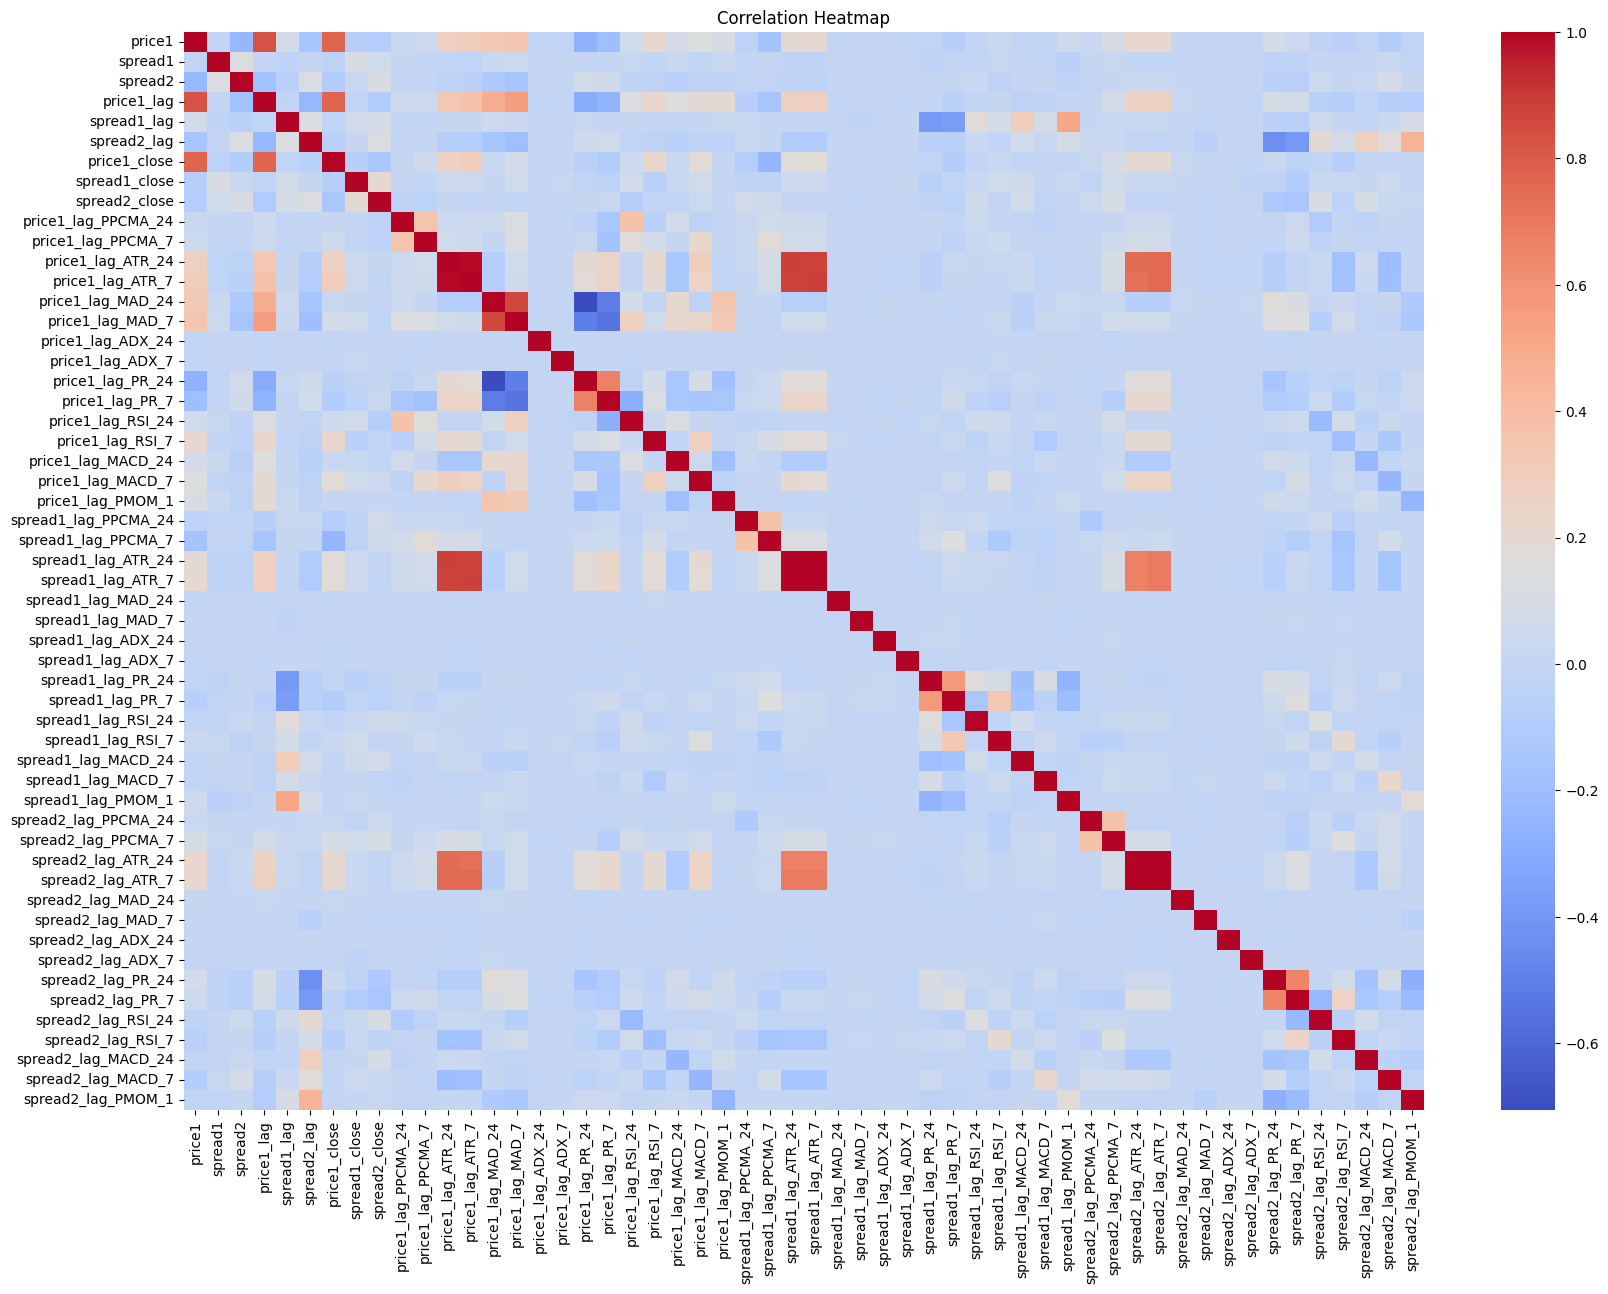

In [268]:
correlation_matrix = price_data.corr()

plt.figure(figsize=(20, 14))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()